# Code for generating plots in paper

In [1]:
%matplotlib inline
import matplotlib

In [2]:
import csv
import numpy as np
import pandas as pd
matplotlib.style.use('seaborn')
import seaborn as sns
sns.color_palette("Paired")
import matplotlib.pyplot as plt
from copy import deepcopy
import mpl_toolkits.axisartist as AA
from mpl_toolkits.axes_grid1 import host_subplot

## Code for generating figures 3, 4

In [3]:
cubic = ["W","V","K","Al","Cu","Pd"]
hcp = ["Ti","Re","Y"]
metals = cubic+hcp

In [4]:
def make_scatter_plot_data(data_frame):
    """Converts the data in the dataframe from it's read in format 
    to the format needed for plotting. Which entails dropping the 
    `mean` and `count` columns from the data."""
    rows = np.asarray(data_frame.index)
    
    data = []
    for row in rows:
        temp = data_frame.ix[:,data_frame.columns.difference(["mean","count"])].loc[row].dropna().values
        for t in temp:
            data.append([float(row),t])
            
    return np.array(data)
        

### Figure 3

In [5]:
def get_mean_data_kpd(method,elements,sub_method=None,cell_sizes=None):
    """Gathers the convergence data for the given method, element, 
    and sub-method, i.e. 'sc' for the Froyen method, and places it
    in a pandas dataframe where each column is a different cell 
    size and each row is a different k-point density. The dataframe also
    contains the mean error per density and numbder of times 
    the density occures.
    
    Args:
        method (str): "SC", "GR", or "MP"
        elements (list of str): A list consisting of the desired 
            elements ("V", "W", "Cu", "Al", "K", "Pd", "Ti", "Y", "Re")
        sub_method (str, optional): The sampling scheme for the 
            Froyen method ("sc", "bcc", "fcc", "hcp"). A sub_method is
            required for the Froyen method and for any other method
            this should be None.
        cell_sizes (list, optional): The list of cell sizes to include in the
            plot.
    
    Returns:
        outdf (pandas.dataframe): A pandas dataframe of the error in
            the calculated energy at each density (row) and supercell 
            (column) in addition to a column of the average error per
            density.
    """
    for el in elements: # loop over element types
        if el in ["Ti","Y","Re"]:
            if cell_sizes is None:
                sizes = range(1,8)
            else:
                sizes = cell_sizes
        else:
            if cell_sizes is None:
                sizes = range(1,12)
            else:
                sizes = cell_sizes
        
        for i in sizes: # loop over element sizes
            data = []
            kpd = []
            # read the file
            if sub_method is None:
                f = open("../data/{0}/{1}_conv/{2}_atom_kpd_conv.csv".format(method,el,i),"r")
            else:
                f = open("../data/{0}/{1}_conv/{2}_{3}_atom_kpd_conv.csv".format(method,el,i,sub_method),"r")
            reader = csv.reader(f,delimiter='\t')
            # parse the file for the data, if this k-point density has occured before 
            # then we take the average of the errors reported (this is rare), otherwise
            # we just add it to the dataframe.
            for row in reader:
                # if the system is hcp we need to divide the answeres by 2
                # in order to get error per atom instead of error per cell.
                if el in ["Ti","Re","Y"]:
                    if float(row[0]) in kpd and float(row[1]) >= 1E-6:
                        loc = kpd.index(float(row[0]))
                        data[loc][1] = (data[loc][1]+(float(row[1])/2.))/2.
                    elif float(row[1]) >= 1E-6:
                        kpd.append(float(row[0]))
                        point = [float(row[0]),float(row[1])/2.]
                        data.append(point)                    
                else:
                    if float(row[0]) in kpd and float(row[1]) >= 1E-6:
                        loc = kpd.index(float(row[0]))
                        data[loc][1] = (data[loc][1]+float(row[1]))/2.
                    elif float(row[1]) >= 1E-6:
                        kpd.append(float(row[0]))
                        point = [float(row[0]),float(row[1])]
                        data.append(point)
                    
            data = np.array(data)
            if len(data) >= 1:
                df = pd.DataFrame(data[:,1:],index=data[:,0])#,columns=[str(i)+' atom'])    
            else:
                # If there was no usable data for an element size print a warning
                print("Method: {0}, element: {1}, size: {2} had no useable "
                      "data".format(method,el,i))
                
            # if the dataframe already exists then add to it, otherwise save the dataframe.
            if i > 1 or el != elements[0]:
                outdf = pd.concat([outdf,df], axis=1)
            else:
                outdf = df

    # find the mean and number of instances for each row. (across element types and cell sizes)
    outdf['mean'] = outdf.mean(axis=1) 
    outdf['count'] = outdf.apply(lambda x: x.count(), axis=1)
    return outdf

In [6]:
# get the data
GR_metals = get_mean_data_kpd("GR", metals)
SC_sc_metals = get_mean_data_kpd("SC", cubic, sub_method="sc")
SC_bcc_metals = get_mean_data_kpd("SC", cubic, sub_method="bcc")
SC_fcc_metals = get_mean_data_kpd("SC", cubic, sub_method="fcc")
SC_hcp_metals = get_mean_data_kpd("SC", hcp, sub_method="hcp")
MP_metals = get_mean_data_kpd("MP", metals)

Method: SC, element: V, size: 1 had no useable data
Method: SC, element: V, size: 1 had no useable data


In [7]:
# convert the data to the plotting format
GR_metals_scat = make_scatter_plot_data(GR_metals)
SC_sc_metals_scat = make_scatter_plot_data(SC_sc_metals)
SC_bcc_metals_scat = make_scatter_plot_data(SC_bcc_metals)
SC_fcc_metals_scat = make_scatter_plot_data(SC_fcc_metals)
SC_hcp_metals_scat = make_scatter_plot_data(SC_hcp_metals)
MP_metals_scat = make_scatter_plot_data(MP_metals)
# combine the Froyen datasets
SC_metals_scat = np.concatenate((SC_sc_metals_scat,SC_bcc_metals_scat),axis=0)
SC_metals_scat = np.concatenate((SC_metals_scat,SC_fcc_metals_scat),axis=0)
SC_metals_scat = np.concatenate((SC_metals_scat,SC_hcp_metals_scat),axis=0)

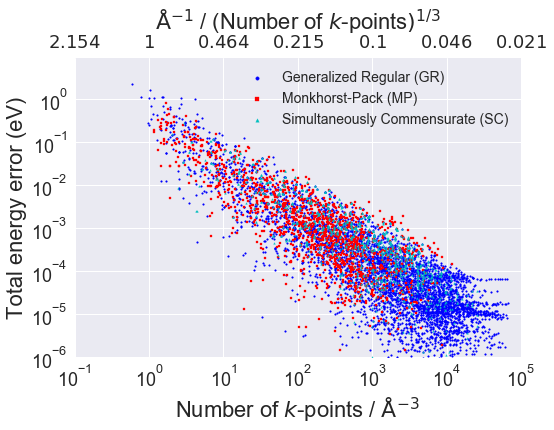

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
 
ax1.scatter(GR_metals_scat[:,0],abs(GR_metals_scat[:,1]),
            label="Generalized Regular (GR)",marker="o",s=3,c='b')
ax1.scatter(MP_metals_scat[:,0],abs(MP_metals_scat[:,1]),
            label="Monkhorst-Pack (MP)",marker="s",s=3,c='r')
ax1.scatter(SC_metals_scat[:,0],abs(SC_metals_scat[:,1]),
            label="Simultaneously Commensurate (SC)", marker="^",s=3,c='c')

ax1.set_xlabel("Number of $k$-points / $\mathrm{\AA}^{-3}$",fontsize=22)
ax1.set_xscale('log')
new_tick_locations = np.array([.1,1,10,100,1000,10000,100000])
ax1.set_xlim(.1,100000)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xlabel("$\mathrm{\AA}^{-1}$ / (Number of $k$-points$)^{1/3}$",
               fontsize=22)
ax2.set_xscale('log')
ax2.set_xticklabels(["1.00","$2.154$","$1$","$0.464$",
                    "$0.215$","$0.1$","$0.046$","$0.021$"],fontsize=18)
ax2.grid(False)

ax1.set_ylabel("Total energy error (eV)",fontsize=22)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(18) 

plt.yscale('log')
plt.ylim(1E-6,9E0)
plt.xlim(1E-1,1E5)
ax1.legend(markerscale=2,fontsize=14)
plt.savefig("../plots/All_methods_KPD.pdf",bbox_inches="tight")
plt.show()

### Figure 4

This plot requires output from an R script held in this directory loess.R. The output data from this script has already been saved to `data/R_workspace/` but if you want to regenerate that ouput you will need to use the R script.

In [11]:
def get_mean_data_ibzkpd(method,elements,sub_method=None):
    """Gathers the convergence data for the given method, element, 
    and sub-method, i.e. 'sc' for the Froyen method, and places it
    in a pandas dataframe where each column is a different cell 
    size and each row is a different irreducible k-point density. 
    The dataframe also contains the mean error per density and
    numbder of times the density occures.
    
    Args:
        method (str): "SC", "GR", or "MP"
        elements (list of str): A list consisting of the desired 
            elements ("V", "W", "Cu", "Al", "K", "Pd", "Ti", "Y", "Re")
        sub_method (str, optional): The sampling scheme for the 
            Froyen method ("sc", "bcc", "fcc", "hcp"). A sub_method is
            required for the Froyen method and for any other method
            this should be None.
    
    Returns:
        outdf (pandas.dataframe): A pandas dataframe of the error in
            the calculated energy at each density (row) and supercell 
            (column) in addition to a column of the average error per
            density.
    """
    for el in elements: # loop over the elements
        if el in ["Ti","Y","Re"]:
            sizes = range(1,8)
        else:
            sizes = range(1,12)
            
        for i in sizes: # loop over the cell sizes
            data = []
            kpd = []
            # read the correct file
            if sub_method is None:
                f = open("../data/{0}/{1}_conv/{2}_atom_IBZKPTS_dese_conv.csv".format(method,el,i),"r")
            else:
                f = open("../data/{0}/{1}_conv/{2}_{3}_atom_IBZKPTS_dese_conv.csv".format(method,el,i,sub_method),"r")
            reader = csv.reader(f,delimiter='\t')
            # parse the file for the data, if this k-point density has occured before 
            # then we take the average of the errors reported (this is rare), otherwise
            # we just add it to the dataframe.
            for row in reader:
                # if the system is hcp we need to divide the answeres by 2
                # in order to get error per atom instead of error per cell.
                if el in ["Ti","Re","Y"]:
                    if float(row[0]) in kpd and float(row[1]) >= 1E-6:
                        loc = kpd.index(float(row[0]))
                        data[loc][1] = (data[loc][1]+(float(row[1])/2.))/2.
                    elif float(row[1]) >= 1E-6:
                        kpd.append(float(row[0]))
                        point = [float(row[0]),float(row[1])/2.]
                        data.append(point)                    
                else:
                    if float(row[0]) in kpd and float(row[1]) >= 1E-6:
                        loc = kpd.index(float(row[0]))
                        data[loc][1] = (data[loc][1]+float(row[1]))/2.
                    elif float(row[1]) >= 1E-6:
                        kpd.append(float(row[0]))
                        point = [float(row[0]),float(row[1])]
                        data.append(point)
                    
            data = np.array(data)
            # If there was no useable data warn the user.
            if len(data) >= 1:
                df = pd.DataFrame(data[:,1:],index=data[:,0])
            else:
                print("Method: {0}, element: {1}, size: {2}".format(method,el,i))
                
            # if the dataframe already exists add to it, otherwise just save it
            if i > 1 or el != elements[0]:
                outdf = pd.concat([outdf,df], axis=1)
            else:
                outdf = df
    # store the mean and count of the kpd instances across elemnts and sizes
    outdf['mean'] = outdf.mean(axis=1) 
    outdf['count'] = outdf.apply(lambda x: x.count(), axis=1)
    return outdf

In [12]:
# Get the raw data from the files
GR_metals_ibz = get_mean_data_ibzkpd("GR", metals)
SC_sc_metals_ibz = get_mean_data_ibzkpd("SC", cubic, sub_method="sc")
SC_bcc_metals_ibz = get_mean_data_ibzkpd("SC", cubic, sub_method="bcc")
SC_fcc_metals_ibz = get_mean_data_ibzkpd("SC", cubic, sub_method="fcc")
SC_hcp_metals_ibz = get_mean_data_ibzkpd("SC", hcp, sub_method="hcp")
MP_metals_ibz = get_mean_data_ibzkpd("MP", metals)

Method: SC, element: V, size: 1
Method: SC, element: V, size: 1


In [13]:
# convert the data to the format needed for plotting
GR_metals_scat_ibz = make_scatter_plot_data(GR_metals_ibz)
SC_sc_metals_scat_ibz = make_scatter_plot_data(SC_sc_metals_ibz)
SC_bcc_metals_scat_ibz = make_scatter_plot_data(SC_bcc_metals_ibz)
SC_fcc_metals_scat_ibz = make_scatter_plot_data(SC_fcc_metals_ibz)
SC_hcp_metals_scat_ibz = make_scatter_plot_data(SC_hcp_metals_ibz)
MP_metals_scat_ibz = make_scatter_plot_data(MP_metals_ibz)

In [14]:
# combine all the Froyen data types
SC_metals_scat_ibz = np.concatenate((SC_sc_metals_scat_ibz,SC_bcc_metals_scat_ibz),axis=0)
SC_metals_scat_ibz = np.concatenate((SC_metals_scat_ibz,SC_fcc_metals_scat_ibz),axis=0)
SC_metals_scat_ibz = np.concatenate((SC_metals_scat_ibz,SC_hcp_metals_scat_ibz),axis=0)

In [16]:
# Save the data to the R_workspace so that the loess smoothing can run on them.
np.savetxt("../data/R_workspace/GR_irkpd.csv",GR_metals_scat_ibz,delimiter="\t")
np.savetxt("../data/R_workspace/SC_irkpd.csv",SC_metals_scat_ibz,delimiter="\t")
np.savetxt("../data/R_workspace/MP_irkpd.csv",MP_metals_scat_ibz,delimiter="\t")

In [5]:
# Read in the loess fit
GR_irkpd_loess = 10**np.genfromtxt("../data/R_workspace/GR_irkpd_loess.csv",delimiter=",")[1:]
MP_irkpd_loess = 10**np.genfromtxt("../data/R_workspace/MP_irkpd_loess.csv",delimiter=",")[1:]
SC_irkpd_loess = 10**np.genfromtxt("../data/R_workspace/SC_irkpd_loess.csv",delimiter=",")[1:]

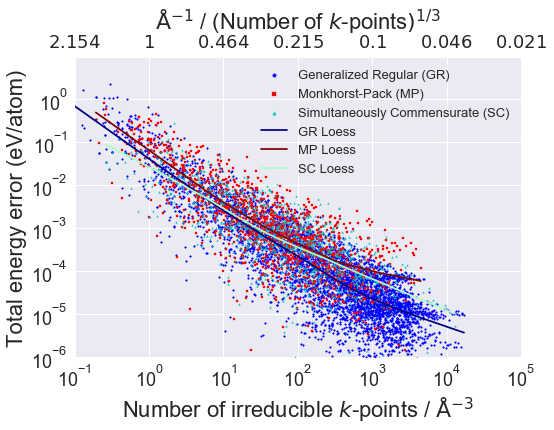

In [21]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
 
ax1.scatter(GR_metals_scat_ibz[:,0],abs(GR_metals_scat_ibz[:,1]),
            label="Generalized Regular (GR)",marker="o",s=3,c='b')
ax1.scatter(MP_metals_scat_ibz[:,0],abs(MP_metals_scat_ibz[:,1]),
            label="Monkhorst-Pack (MP)",marker="s",s=3,c='r')
ax1.scatter(SC_metals_scat_ibz[:,0],abs(SC_metals_scat_ibz[:,1]),
            label="Simultaneously Commensurate (SC)",marker="^",s=3,c='c')

ax1.plot(GR_irkpd_loess[:,0],GR_irkpd_loess[:,1],label="GR Loess",c="#000080")
ax1.plot(MP_irkpd_loess[:,0],MP_irkpd_loess[:,1],label="MP Loess",c="#800000")
ax1.plot(SC_irkpd_loess[:,0],SC_irkpd_loess[:,1],label="SC Loess",c="#aaffc3")
ax1.set_xlabel("Number of irreducible $k$-points / $\mathrm{\AA}^{-3}$",
               fontsize=22)
ax1.set_xscale('log')

new_tick_locations = np.array([.1,1,10,100,1000,10000,100000])
ax1.set_xlim(.1,100000)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xlabel("$\mathrm{\AA}^{-1}$ / (Number of $k$-points$)^{1/3}$",
              fontsize=22)
ax2.set_xscale('log')
ax2.set_xticklabels(["1.00","$2.154$","$1$","$0.464$",
                    "$0.215$","$0.1$","$0.046$","$0.021$"],fontsize=18)
ax2.grid(False)

ax1.set_ylabel("Total energy error (eV/atom)",fontsize=22)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
plt.yscale('log')
plt.ylim(1E-6,9E0)
plt.xlim(1E-1,1E5)

handles,labels = ax1.get_legend_handles_labels()
handles = [handles[3],handles[4],handles[5],handles[0],handles[1],handles[2]]
labels = [labels[3],labels[4],labels[5],labels[0],labels[1],labels[2]]
ax1.legend(handles, labels, markerscale=2,fontsize=13)

plt.savefig("../plots/All_methods_IRKPD.pdf",bbox_inches="tight")
plt.show()

## Codes to make figures 6 and 7

In [22]:
# Get data for simple Si runs and simple Al runs

# Si
Si_sc = []
Si_bcc = []
Si_fcc = []

f = open('../data/Si_by_grid/sc_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    Si_sc.append([int(row[0]),float(row[1])])
    
f = open('../data/Si_by_grid/bcc_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    Si_bcc.append([int(row[0]),float(row[1])])

f = open('../data/Si_by_grid/fcc_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    Si_fcc.append([int(row[0]),float(row[1])])

# Al data
Al_bcc = []
Al_fcc = []
Al_sc = []

f = open('../data/Al_by_grid/bcc_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    Al_bcc.append([int(row[0]),float(row[1])])
    
f = open('../data/Al_by_grid/fcc_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    Al_fcc.append([int(row[0]),float(row[1])])
    
f = open('../data/Al_by_grid/sc_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    Al_sc.append([int(row[0]),float(row[1])])

# Convert to numpy arrays for ease of later use
Si_sc = np.array(Si_sc)
Si_bcc = np.array(Si_bcc)
Si_fcc = np.array(Si_fcc)
Al_bcc = np.array(Al_bcc)
Al_fcc = np.array(Al_fcc)
Al_sc = np.array(Al_sc)

### Figure 6

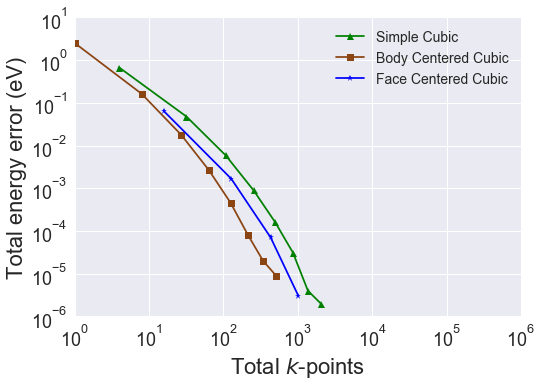

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(Si_sc[:8,0],Si_sc[:8,1],label="Simple Cubic",c='g',marker='^')
ax.plot(Si_fcc[:8,0],Si_fcc[:8,1],label="Body Centered Cubic",c='saddlebrown',marker='s')
ax.plot(Si_bcc[:4,0],Si_bcc[:4,1],label="Face Centered Cubic",c='b',marker='*')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-6,10)
plt.xlim(1E0,1E6)
plt.legend(fontsize=14)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18) 

plt.ylabel("Total energy error (eV)",fontsize=22)
plt.xlabel("Total $k$-points",fontsize=22)
plt.savefig('../plots/Si_grid_type.pdf',bbox_inches="tight")
plt.show()

### Figure 7

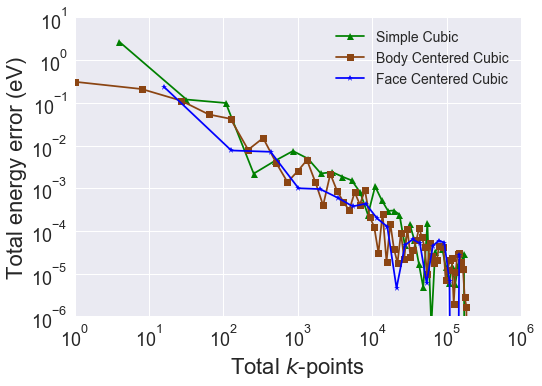

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(Al_sc[:,0],Al_sc[:,1],label="Simple Cubic",c='g',marker='^')
ax.plot(Al_fcc[:,0],Al_fcc[:,1],label="Body Centered Cubic",c='saddlebrown',marker='s')
ax.plot(Al_bcc[:,0],Al_bcc[:,1],label="Face Centered Cubic",c='b',marker='*')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-6,10)
plt.xlim(1E0,1E6)
plt.legend(fontsize=14)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18) 

plt.ylabel("Total energy error (eV)",fontsize=22)
plt.xlabel("Total $k$-points",fontsize=22)
plt.savefig('../plots/Al_grid_type.pdf',bbox_inches="tight")
plt.show()

## Make Figure 5

This plot requires output from an R script held in this directory loess.R. The output data from this script has already been saved to `data/R_workspace/` but if you want to regenerate that ouput you will need to use the R script.

In [6]:
def interpolate(p1,p2,y):
    """Intepolates the line between two points.
    
    Args:
        p1 (list): [x,y]
        p2 (list): [x,y]
        
    Returns:
        interpolated x value.
    """
    
    slope = (p2[1]-p1[1])/(p2[0]-p1[0])
    return p2[0]+(y-min(p2[1],p1[1]))/slope

In [7]:
def make_ratios(top,bottom):
    """Makes the ratio of the top vs the bottom methods 
    of grid generation in DFT in terms of the irreducible
    k-point density of top/irreducible k-point density of bottom
    at a given error value.
    
    top (list): the irreducible k-point densities and errors for 
        the top method.
        
    bottom (list): the irreducible k-point densities and errors for 
        the top method.
        
    Returns:
        numpy.array of the erros and ratios [error,ratio].
    """
    ratio = []
    count = 0
    for ti in top:
        t_dens = ti[0]
        t_err = ti[1]
        found = False
        for j in range(len(bottom)):
            bi = bottom[j]
            if bi[1] < t_err:
                found = True 
                b_dens = interpolate(bottom[j-1],bi,t_err)
                break 
        if found == True:
            ratio.append([t_err,t_dens/b_dens])
            
    return np.array(ratio)

In [8]:
# get the data and make the take the ratios of the methods
GR_irkpd_loess = 10**np.genfromtxt("../data/R_workspace/GR_irkpd_loess.csv",delimiter=",")[1:]
MP_irkpd_loess = 10**np.genfromtxt("../data/R_workspace/MP_irkpd_loess.csv",delimiter=",")[1:]
SC_irkpd_loess = 10**np.genfromtxt("../data/R_workspace/SC_irkpd_loess.csv",delimiter=",")[1:]

MP_GR = make_ratios(MP_irkpd_loess,GR_irkpd_loess)
SC_GR = make_ratios(SC_irkpd_loess,GR_irkpd_loess)

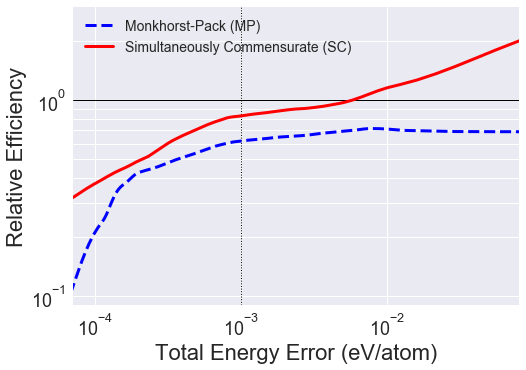

In [14]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.axhline(1,c="k",linewidth=1)
ax1.axvline(1E-3,ls='dotted',c='k',linewidth=1)
ax1.plot(MP_GR[:,0],1/MP_GR[:,1],label="Monkhorst-Pack (MP)",linewidth=3,c='b',ls='--')
ax1.plot(SC_GR[:,0],1/SC_GR[:,1],label="Simultaneously Commensurate (SC)",linewidth=3,c='r')

ax1.set_yscale("log")
ax1.set_xlabel("Total Energy Error (eV/atom)",fontsize=22)
ax1.set_ylabel("Relative Efficiency",fontsize=22)
ax1.yaxis.grid(True,which="minor")
plt.yscale("log")
plt.loglog()

plt.xlim(7E-5,8E-2)
plt.ylim(9E-2,3E0)
plt.legend(fontsize=14)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(18) 

plt.savefig("../plots/Relative_efficiency.pdf",bbox_inches="tight")
plt.show()

## Fig X

In [8]:
# combine the datasets from figure 3
all_scat = np.concatenate((SC_sc_metals_scat,SC_bcc_metals_scat),axis=0)
all_scat = np.concatenate((all_scat,SC_fcc_metals_scat),axis=0)
all_scat = np.concatenate((all_scat,SC_hcp_metals_scat),axis=0)
all_scat = np.concatenate((all_scat,MP_metals_scat),axis=0)
all_scat = np.concatenate((all_scat,GR_metals_scat),axis=0)

In [9]:
# get the data for the primitive cell
prim_GR_metals = get_mean_data_kpd("GR", metals, cell_sizes=[1])
prim_SC_sc_metals = get_mean_data_kpd("SC", cubic, sub_method="sc", cell_sizes=[1])
prim_SC_bcc_metals = get_mean_data_kpd("SC", cubic, sub_method="bcc", cell_sizes=[1])
prim_SC_fcc_metals = get_mean_data_kpd("SC", cubic, sub_method="fcc", cell_sizes=[1])
prim_SC_hcp_metals = get_mean_data_kpd("SC", hcp, sub_method="hcp", cell_sizes=[1])
prim_MP_metals = get_mean_data_kpd("MP", metals, cell_sizes=[1])
# convert the data to the plotting format
prim_GR_metals_scat = make_scatter_plot_data(prim_GR_metals)
prim_SC_sc_metals_scat = make_scatter_plot_data(prim_SC_sc_metals)
prim_SC_bcc_metals_scat = make_scatter_plot_data(prim_SC_bcc_metals)
prim_SC_fcc_metals_scat = make_scatter_plot_data(prim_SC_fcc_metals)
prim_SC_hcp_metals_scat = make_scatter_plot_data(prim_SC_hcp_metals)
prim_MP_metals_scat = make_scatter_plot_data(prim_MP_metals)
# combine the Froyen datasets
prim_scat = np.concatenate((prim_SC_sc_metals_scat,prim_SC_fcc_metals_scat),axis=0)
prim_scat = np.concatenate((prim_scat,prim_SC_bcc_metals_scat),axis=0)
prim_scat = np.concatenate((prim_scat,prim_SC_hcp_metals_scat),axis=0)
prim_scat = np.concatenate((prim_scat,prim_MP_metals_scat),axis=0)
prim_scat = np.concatenate((prim_scat,prim_GR_metals_scat),axis=0)

Method: SC, element: V, size: 1 had no useable data
Method: SC, element: V, size: 1 had no useable data


In [10]:
print("There are {0} primitive cell calculations in the data. "
      "This means that {1}% of the total convergence data is from "
      "primitive cells.".format(len(prim_scat),
                                np.round((len(prim_scat)/float(len(all_scat)))*100,2)))

There are 846 primitive cell calculations in the data. This means that 12.17% of the total convergence data is from primitive cells.


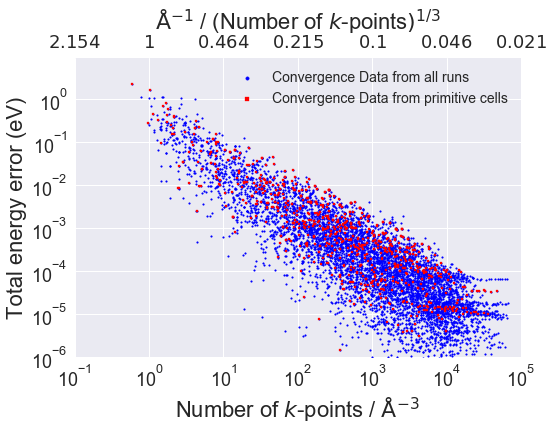

In [19]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
 
ax1.scatter(all_scat[:,0],abs(all_scat[:,1]),
            label="Convergence Data from all runs",marker="o",s=3,c='b')
ax1.scatter(prim_scat[:,0],abs(prim_scat[:,1]),
            label="Convergence Data from primitive cells",marker="s",s=3,c='r')
#ax1.axvline(x=5000)
#ax1.axvline(x=1000)
#ax1.axhline(y=1E-3)
#ax1.axhline(y=3E-3)

ax1.set_xlabel("Number of $k$-points / $\mathrm{\AA}^{-3}$",fontsize=22)
ax1.set_xscale('log')
new_tick_locations = np.array([.1,1,10,100,1000,10000,100000])
ax1.set_xlim(.1,100000)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xlabel("$\mathrm{\AA}^{-1}$ / (Number of $k$-points$)^{1/3}$",
               fontsize=22)
ax2.set_xscale('log')
ax2.set_xticklabels(["1.00","$2.154$","$1$","$0.464$",
                    "$0.215$","$0.1$","$0.046$","$0.021$"],fontsize=18)
ax2.grid(False)

ax1.set_ylabel("Total energy error (eV)",fontsize=22)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(18) 

plt.yscale('log')
plt.ylim(1E-6,9E0)
plt.xlim(1E-1,1E5)
ax1.legend(markerscale=2,fontsize=14)
plt.savefig("../plots/prim_vs_all_KPD.pdf",bbox_inches="tight")
plt.show()

In [79]:
each_el = {}
for el in metals:# get the data for the primitive cell
    if el in hcp:
        prim_GR_metals = get_mean_data_kpd("GR", [el], cell_sizes=[1])
        prim_SC_hcp_metals = get_mean_data_kpd("SC", [el], sub_method="hcp", cell_sizes=[1])
        prim_MP_metals = get_mean_data_kpd("MP", [el], cell_sizes=[1])
        # convert the data to the plotting format
        prim_GR_metals_scat = make_scatter_plot_data(prim_GR_metals)
        prim_SC_hcp_metals_scat = make_scatter_plot_data(prim_SC_hcp_metals)
        prim_MP_metals_scat = make_scatter_plot_data(prim_MP_metals)
        # combine the Froyen datasets
        prim_scat = prim_SC_hcp_metals_scat
        prim_scat = np.concatenate((prim_scat,prim_MP_metals_scat),axis=0)
        prim_scat = np.concatenate((prim_scat,prim_GR_metals_scat),axis=0)
    else:
        if el == "V":
            prim_GR_metals = get_mean_data_kpd("GR", [el], cell_sizes=[1])
            prim_SC_sc_metals = get_mean_data_kpd("SC", [el], sub_method="sc", cell_sizes=[1])
            prim_MP_metals = get_mean_data_kpd("MP", [el], cell_sizes=[1])
            # convert the data to the plotting format
            prim_GR_metals_scat = make_scatter_plot_data(prim_GR_metals)
            prim_SC_sc_metals_scat = make_scatter_plot_data(prim_SC_sc_metals)
            prim_MP_metals_scat = make_scatter_plot_data(prim_MP_metals)
            # combine the Froyen datasets
            prim_scat = prim_SC_sc_metals_scat
            prim_scat = np.concatenate((prim_scat,prim_MP_metals_scat),axis=0)
            prim_scat = np.concatenate((prim_scat,prim_GR_metals_scat),axis=0)
        else:
            prim_GR_metals = get_mean_data_kpd("GR", [el], cell_sizes=[1])
            prim_SC_sc_metals = get_mean_data_kpd("SC", [el], sub_method="sc", cell_sizes=[1])
            prim_SC_bcc_metals = get_mean_data_kpd("SC", [el], sub_method="bcc", cell_sizes=[1])
            prim_SC_fcc_metals = get_mean_data_kpd("SC", [el], sub_method="fcc", cell_sizes=[1])
            prim_MP_metals = get_mean_data_kpd("MP", [el], cell_sizes=[1])
            # convert the data to the plotting format
            prim_GR_metals_scat = make_scatter_plot_data(prim_GR_metals)
            prim_SC_sc_metals_scat = make_scatter_plot_data(prim_SC_sc_metals)
            prim_SC_bcc_metals_scat = make_scatter_plot_data(prim_SC_bcc_metals)
            prim_SC_fcc_metals_scat = make_scatter_plot_data(prim_SC_fcc_metals)
            prim_MP_metals_scat = make_scatter_plot_data(prim_MP_metals)
            # combine the Froyen datasets
            prim_scat = np.concatenate((prim_SC_sc_metals_scat,prim_SC_fcc_metals_scat),axis=0)
            prim_scat = np.concatenate((prim_scat,prim_SC_bcc_metals_scat),axis=0)
            prim_scat = np.concatenate((prim_scat,prim_MP_metals_scat),axis=0)
            prim_scat = np.concatenate((prim_scat,prim_GR_metals_scat),axis=0)
    each_el[el] = prim_scat

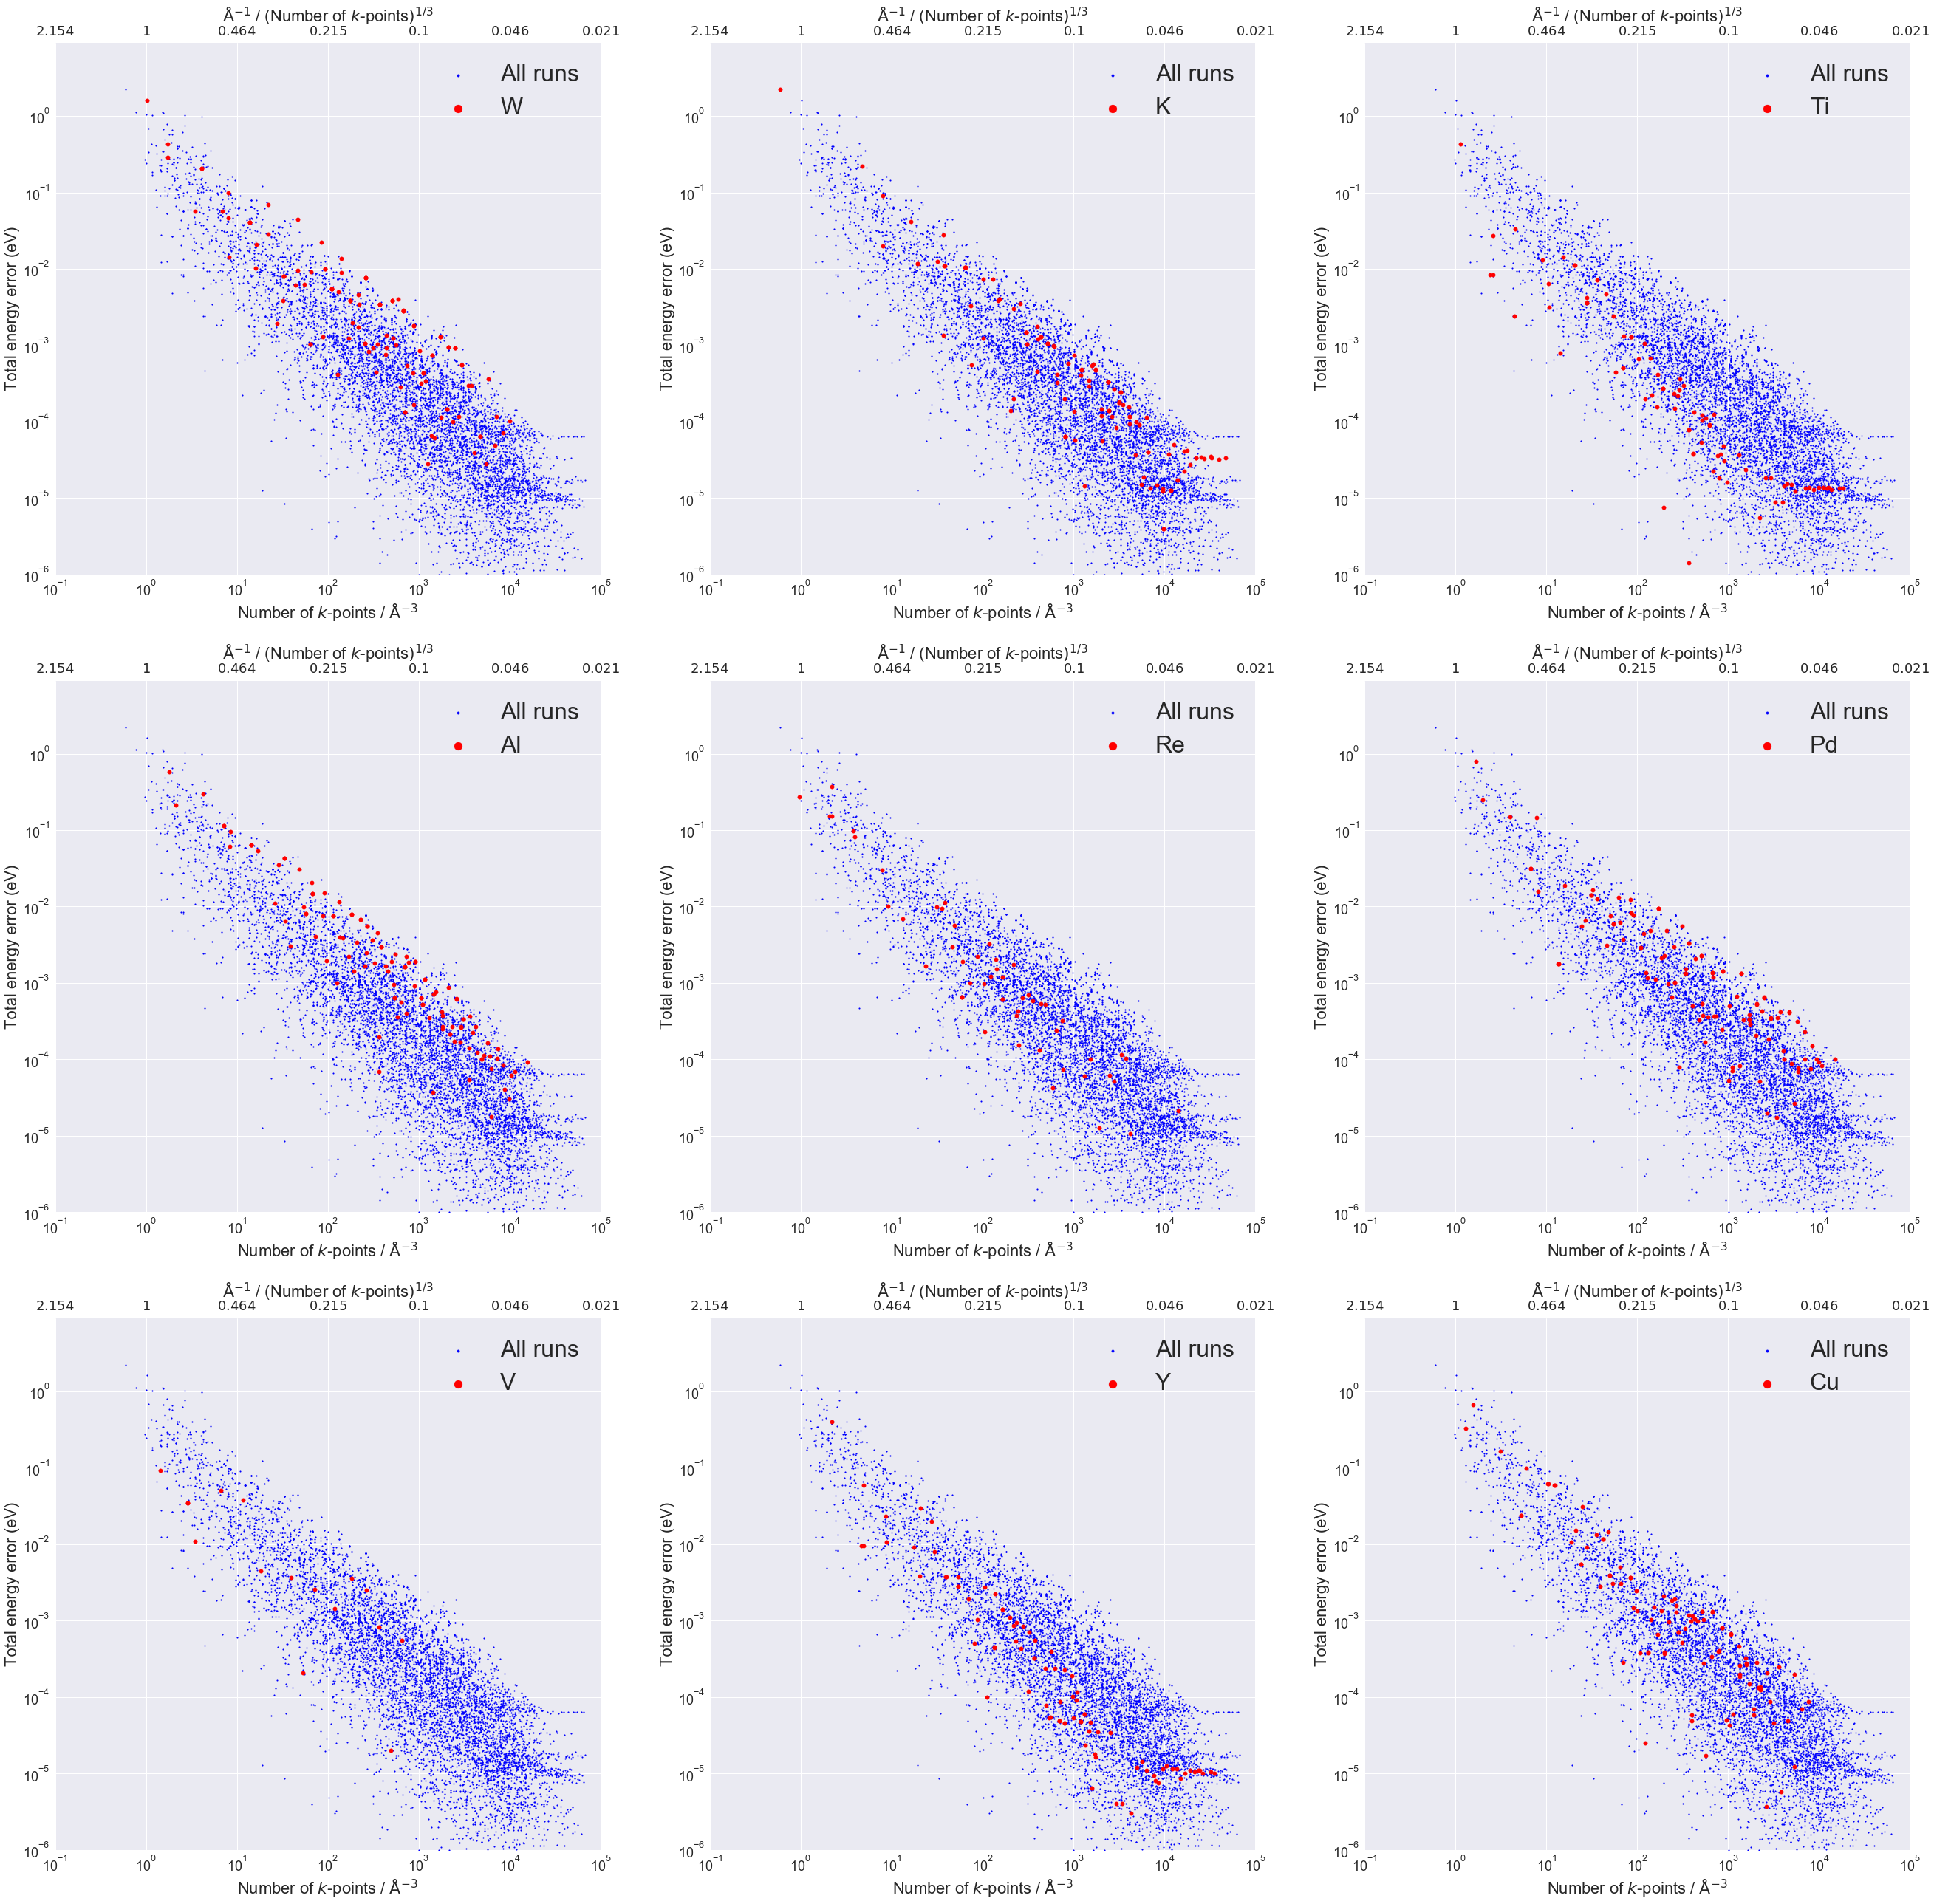

In [96]:
fig = plt.figure(figsize=(45,45))
count = 1
for el, scat in each_el.items():
    ax1 = fig.add_subplot(3,3,count)

    ax2 = ax1.twiny()
 
    ax1.scatter(all_scat[:,0],abs(all_scat[:,1]),
            label="All runs",marker="o",s=3,c='b')
    ax1.scatter(scat[:,0],abs(scat[:,1]),
                label=el, s=30, marker="o",c='r')

    ax1.set_xlabel("Number of $k$-points / $\mathrm{\AA}^{-3}$",fontsize=22)
    ax1.set_xscale('log')
    new_tick_locations = np.array([.1,1,10,100,1000,10000,100000])
    ax1.set_xlim(.1,100000)
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(new_tick_locations)
    ax2.set_xlabel("$\mathrm{\AA}^{-1}$ / (Number of $k$-points$)^{1/3}$",
               fontsize=22)
    ax2.set_xscale('log')
    ax2.set_xticklabels(["1.00","$2.154$","$1$","$0.464$",
                    "$0.215$","$0.1$","$0.046$","$0.021$"],fontsize=18)
    ax2.grid(False)

    ax1.set_ylabel("Total energy error (eV)",fontsize=22)
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(18) 

    plt.yscale('log')
    plt.ylim(1E-6,9E0)
    plt.xlim(1E-1,1E5)
    ax1.legend(markerscale=2,fontsize=32)
    count += 1
plt.savefig("../plots/prim_vs_all_each_element_KPD.pdf",bbox_inches="tight")
plt.show()

## Fig Y